In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import hamming_loss
from sklearn import ensemble
from sklearn import tree


from project_tools import lasso_feature_selection, accuracy_metrics

from sklearn.datasets import load_breast_cancer

# Loading in the Data

In [2]:
cancer = load_breast_cancer()
df = pd.DataFrame(data=cancer['data'], columns=cancer.feature_names)
tf = pd.DataFrame(data=cancer['target'], columns=['outcome'])

This data set was loaded from the `sklearn.datasets` package. It is a copy of the UCI ML Breast Cancer Wisconsin (Diagnostic data set). The dataset represents measurements taken from tumors located on subject's breasts. There are a total of 569 subjects with 212 having malignant tumors and the other 357 having cancerous tumors. There are a total of 30 variables in the dataset that are obtained through the following attributes

* **radius** - mean of distances from center to points on the perimeter
* **texture** - standard deviation of gray-scale values
* **perimeter**
* **area**
* **smoothness** - local variation in radius lengths
* **compactness** - $\frac{\frac{perimeter^2}{area} - 1}{n}$
* **concavity** - severity of concave portions of the contour
* **concave points** - number of concave portions of the contour
* **symmetry**
* **fractional dimension** - coastline approximation - 1

For each of the attributes listed above the mean, standard error, and worst or largest (both are calculated by taking the mean of the three largest values) are documented for every tumor in the dataset. 

In this report, I will try to build a classification model through different methods. The optimal model will have a high accuracy rate, and F1 score close to 1, as well as a low false negative rate since in this scenario false negaties are the most dangerous outcome whereas false positives are not that harmful.

# Feature Selection

## Brute Force Search 
The most straightforward form of feature selection is to simply search through all possible subsets of features of the desired size, and to compute which one has the lowest error. In some cases this can be executed, but usually it is prohibitively expensive.

In [3]:
n_features = 3
min_err = np.inf
best_features = None
for features in itertools.combinations(list(df.columns), n_features):
    reg = LinearRegression(fit_intercept=True).fit(df[list(features)], tf)
    err = mean_squared_error(reg.predict(df[list(features)]), tf)
    if err < min_err:
        best_features = features
        min_err = err

print('Selected features:', best_features)

Selected features: ('worst radius', 'worst texture', 'worst concave points')


## Forward Feature Selection

This is a greedy procedure. First, we pick the feature whose one-dimensional linear regression provides the smallest error. Then, we pick, among the remaining features, the one whose two-dimensional linear regression with the first feature provides the smallest error. Then, we repeat for the desired number of features.

In [4]:
remaining_features = list(df.columns)
selected_features = []

while len(selected_features) < n_features:
    print('Choosing among:', remaining_features)
    min_err = np.inf
    best_feat = None

    for feat in remaining_features:
        selected_features.append(feat)
        reg = LinearRegression(fit_intercept=True).fit(df[selected_features], tf)
        err = mean_squared_error(reg.predict(df[selected_features]), tf)
        if err < min_err:
            best_feat = feat
            min_err = err
        selected_features.remove(feat)
    selected_features.append(best_feat)
    remaining_features.remove(best_feat)
    print('Select:', best_feat)
    print()

print('Selected features:', selected_features)

Choosing among: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
Select: worst concave points

Choosing among: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal

**note** our brute force and forward search selected the same three attributes

## Lasso

One of the most important uses of the LASSO is for feature selection. That is, often we have a data set with many features, but we want to perform linear regression only on a small set of "most representative" features. There are many methods for this feature subset selection problem, which we will now explore.

we assume our cancer data $\boldsymbol{X}\in\mathbb{R}^{n\times 10}$ and $\boldsymbol{y}\in\mathbb{R}^{n}$ come from a linear model
\begin{equation*}
y_i = \boldsymbol{X}_i\boldsymbol{\beta} + \varepsilon_i, \qquad \boldsymbol{\varepsilon}\sim \mathcal{N}(0,\boldsymbol{I})
\end{equation*}
where $\boldsymbol{\beta}\in\mathbb{R}^{10}$ is unknown and satisfies $\#\{1\le i \le 10: \boldsymbol{\beta}_i \neq 0\} \le 3$. That is, we are looking for the 3 columns of $\boldsymbol{X}$ which best predict the outcome $\boldsymbol{y}$.

To use the LASSO for feature selection, we recall that for regularization strength $\alpha=0$ we have OLS and that for regularization strength $\alpha\to\infty$ we have the all-zeros coefficient vector. Thus, we can use LASSO for feature select by incrementally increasing $\alpha$ until the desired number of coefficients are non-zero.

In [5]:
#check if this is supposed to be training set
print("LASSO Feature Selection")
lasso_feature_selection.lasso_features(df, tf)

LASSO Feature Selection
[ 0.          0.00201262 -0.          0.00044326 -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.00120557 -0.         -0.         -0.         -0.
 -0.         -0.         -0.07144918 -0.01478775 -0.01554386  0.00073623
 -0.         -0.         -0.00496597 -0.         -0.         -0.        ]
Index(['worst radius', 'worst texture', 'worst perimeter'], dtype='object')


### Estimating sparse mixed effects

As a final application, we will consider adding interaction terms to our linear model which we will do from the $\texttt{PolynomialFeatures}$ function that's within the $\texttt{sklearn.preprocessing}$ package:

In [6]:
lasso_feature_selection.ten_mixed_features(df, tf)

[-0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.02001945 -0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.06502124 -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         

# Building Classification models

## Forward Search Feature Selection Logistic Model

Metrics for Training Data
TP=147, TN=283, FP=7, FN=18
precision=0.9545, recall=0.8909, fpr=0.0241, fnr=0.1091
f1_score=0.9216

Metrics for Testing Data
TP=43, TN=66, FP=1, FN=4
precision=0.9773, recall=0.9149, fpr=0.0149, fnr=0.0851
f1_score=0.9451


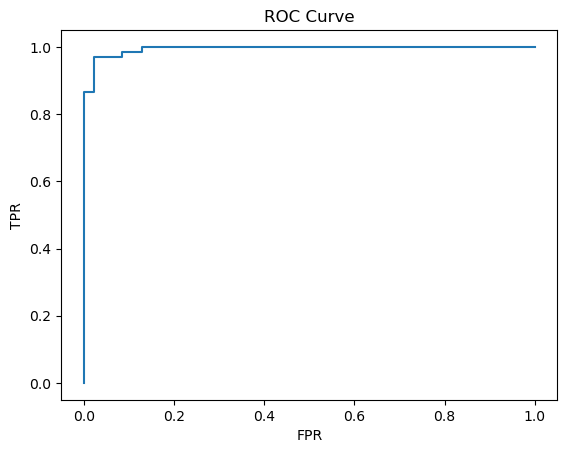

In [7]:
df_forward_search = df[['worst concave points', 'worst radius', 'worst texture']]
df_forward_train, df_forward_test, tf_forward_train, tf_forward_test = train_test_split(df_forward_search, tf['outcome'], test_size=0.20)

forward_model = LogisticRegression().fit(df_forward_train, tf_forward_train)

print("Metrics for Training Data")
accuracy_metrics.scores(forward_model.predict(df_forward_train), tf_forward_train)


print("\nMetrics for Testing Data")
accuracy_metrics.scores(forward_model.predict(df_forward_test), tf_forward_test)

forward_fpr, forward_tpr = accuracy_metrics.roc_curve(forward_model, df_forward_test, tf_forward_test)

### Lasso Features and Logistic Model

Metrics for Training Data
TP=162, TN=270, FP=8, FN=15
precision=0.9529, recall=0.9153, fpr=0.0288, fnr=0.0847
f1_score=0.9337

Metrics for Testing Data
TP=33, TN=75, FP=4, FN=2
precision=0.8919, recall=0.9429, fpr=0.0506, fnr=0.0571
f1_score=0.9167


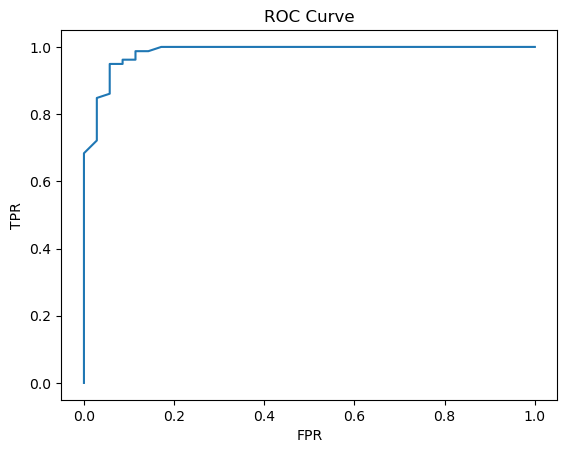

In [8]:
lasso_df = df[['worst radius', 'worst texture', 'worst perimeter']]
df_lasso_train, df_lasso_test, tf_lasso_train, tf_lasso_test = train_test_split(lasso_df, tf['outcome'], test_size=0.20)

lasso_model = LogisticRegression().fit(df_lasso_train, tf_lasso_train)

print("Metrics for Training Data")
accuracy_metrics.scores(lasso_model.predict(df_lasso_train), tf_lasso_train)


print("\nMetrics for Testing Data")
accuracy_metrics.scores(lasso_model.predict(df_lasso_test), tf_lasso_test)

lasso_fpr, lasso_tpr = accuracy_metrics.roc_curve(lasso_model, df_lasso_test, tf_lasso_test)

### Sparse Mixed Features on Logistic Model

Metrics for Training Data
TP=150, TN=282, FP=6, FN=17
precision=0.9615, recall=0.8982, fpr=0.0208, fnr=0.1018
f1_score=0.9288

Metrics for Testing Data
TP=44, TN=67, FP=2, FN=1
precision=0.9565, recall=0.9778, fpr=0.0290, fnr=0.0222
f1_score=0.9670


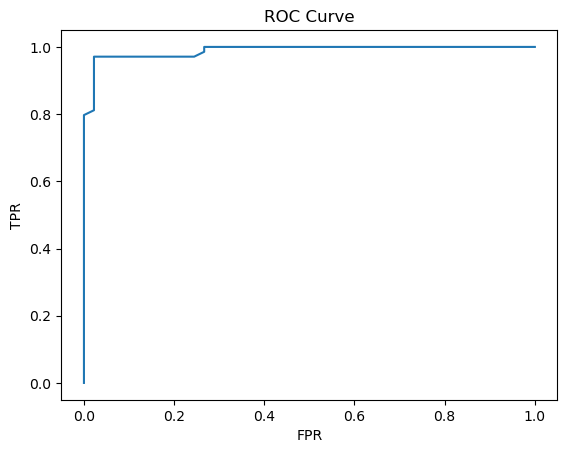

In [9]:
sparse_df = df[['mean concave points', 'worst radius', 'worst smoothness', 'worst symmetry', 'worst texture', 'worst concave points']]
df_sparse_train, df_sparse_test, tf_sparse_train, tf_sparse_test = train_test_split(sparse_df, tf['outcome'], test_size=0.20)

sparse_model = LogisticRegression().fit(df_sparse_train, tf_sparse_train)

print("Metrics for Training Data")
accuracy_metrics.scores(sparse_model.predict(df_sparse_train), tf_sparse_train)


print("\nMetrics for Testing Data")
accuracy_metrics.scores(sparse_model.predict(df_sparse_test), tf_sparse_test)


sparse_fpr, sparse_tpr = accuracy_metrics.roc_curve(sparse_model, df_sparse_test, tf_sparse_test)

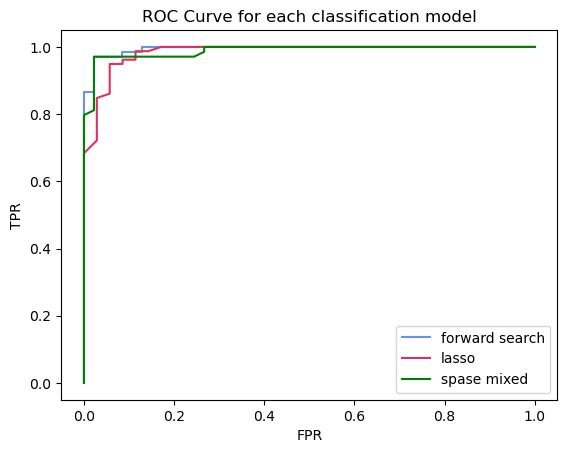

In [12]:
plt.plot(forward_fpr, forward_tpr, label = 'forward search', color = "#6495ED")
plt.plot(lasso_fpr, lasso_tpr, label = 'lasso', color = '#DE3163')
plt.plot(sparse_fpr, sparse_tpr, label = 'spase mixed', color = '#008000')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC Curve for each classification model')
plt.show()

## Decision Trees




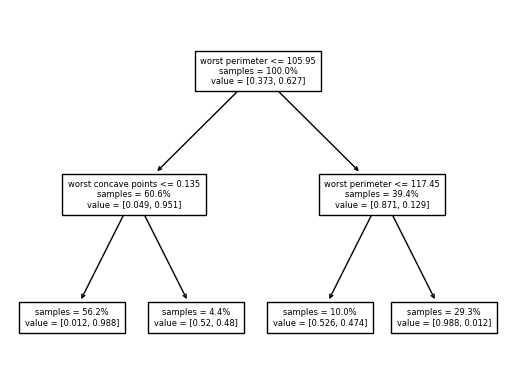

In [13]:
clf = tree.DecisionTreeClassifier(max_depth=2, criterion='entropy').fit(df, tf)
plott = tree.plot_tree(clf, fontsize=6, feature_names=df.columns, impurity=False, proportion=True)

We interpret the content of each cell as follows: The top row determines the decision rule (True is left, and False is right); the second row "samples" describes the proportion of data points that go through this cell; the "value" vector describes the proportion of points at this cell that fall into each class. So, if we have a new data point and we follow its path to a leaf of the tree, we assign its probability of falling into each class to be the values vector

There are lots of parameters that we can vary when we construct decision trees. Perhaps the most important are:
- $\texttt{max\_depth}$, which controls the size of the tree and can be regarded as a certain type of model complexity
- $\texttt{criterion}$, which controls the way that model chooses a split value at each cell.

You can also check out the documentation for lots of further parameters that can be tuned.

/tmp/ipykernel_240/862483.py:2: RuntimeWarning: divide by zero encountered in log
  entrs = -(ps*np.log(ps) +(1-ps)*np.log(1-ps))/(2*np.log(2))
/tmp/ipykernel_240/862483.py:2: RuntimeWarning: invalid value encountered in multiply
  entrs = -(ps*np.log(ps) +(1-ps)*np.log(1-ps))/(2*np.log(2))


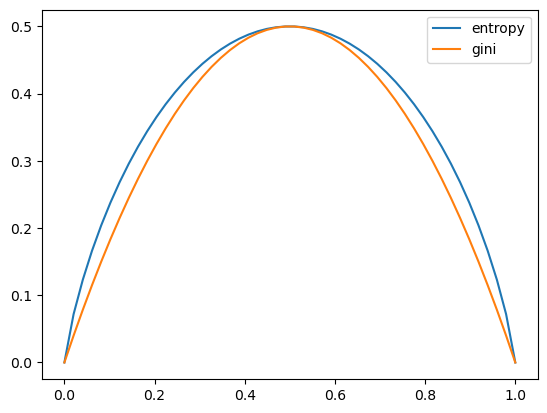

In [14]:
ps = np.linspace(0,1)
entrs = -(ps*np.log(ps) +(1-ps)*np.log(1-ps))/(2*np.log(2))
entrs[0] = 0
entrs[-1] = 0
ginis = 2*ps*(1-ps)

plt.plot(ps, entrs, label='entropy')
plt.plot(ps, ginis, label='gini')
plt.legend()

Now compare the performance of the decision tree classifier when the $\texttt{criterion}$ varies between $\texttt{entropy}$ and $\texttt{gini}$. That is, use sample splitting or cross-validation to estimate the error, and compare this error between the two choices.

In [17]:
k = 10
kf_loss_entr = np.zeros(k)
kf_loss_gini = np.zeros(k)

kf = KFold(n_splits = k)
j = 0

for (train, test) in kf.split(df):
    df_train = df.loc[train]
    tf_train = tf.loc[train]
    df_test = df.loc[test]
    tf_test = tf.loc[test]
        
    clf_entr = tree.DecisionTreeClassifier(max_depth=2, criterion='entropy').fit(df_train, tf_train)
    clf_gini = tree.DecisionTreeClassifier(max_depth=2, criterion='gini').fit(df_train, tf_train)

    kf_loss_entr[j] = hamming_loss(tf_test, clf_entr.predict(df_test))
    kf_loss_gini[j] = hamming_loss(tf_test, clf_gini.predict(df_test))
    j += 1

print('Hamming loss with entropy criterion:', np.mean(kf_loss_entr))
print('Hamming loss with gini criterion:', np.mean(kf_loss_gini))

Hamming loss with entropy criterion: 0.1106516290726817
Hamming loss with gini criterion: 0.08427318295739349


In [18]:
#build classifier with gini criterion

## Random forests for classification

One of the most important ensemble methods in machine learning is a random forest, which is an ensemble of decision trees. In this problem, we'll use the built-in random forest methods to perform classification

Use the $\texttt{RandomForestClassifier}$ model in the $\texttt{sklearn.ensemble}$ package to perform classification on this data set, where the $\texttt{n\_estimators}$ parameter is varied from 1to 30.

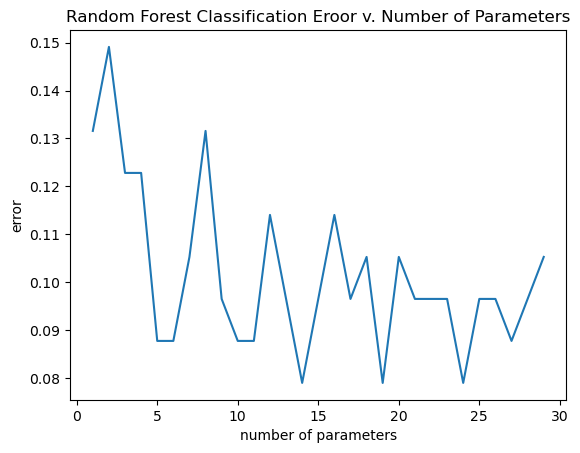

In [19]:
df_train, df_test, tf_train, tf_test = train_test_split(df, tf['outcome'], test_size=0.20)

nes = np.arange(1,30,1)
errs = np.zeros_like(nes, dtype='float')

j = 0
for ne in nes:
    clf = ensemble.RandomForestClassifier(n_estimators=ne).fit(df_train, tf_train)
    errs[j] = hamming_loss(tf_test, clf.predict(df_test))
    j += 1

plt.plot(nes, errs)
plt.xlabel('number of parameters')
plt.ylabel('error')
plt.title('Random Forest Classification Eroor v. Number of Parameters')
plt.show()

having 28 parameters results in the lowest error

In [20]:
rf = ensemble.RandomForestClassifier(n_estimators=28).fit(df_train, tf_train)

print('training dataset metrics')
accuracy_metrics.scores(rf.predict(df_train), tf_train)
print('\ntesting dataset metrics')
accuracy_metrics.scores(rf.predict(df_test), tf_test)

training dataset metrics
TP=161, TN=294, FP=0, FN=0
precision=1.0000, recall=1.0000, fpr=0.0000, fnr=0.0000
f1_score=1.0000

testing dataset metrics
TP=46, TN=59, FP=4, FN=5
precision=0.9200, recall=0.9020, fpr=0.0635, fnr=0.0980
f1_score=0.9109


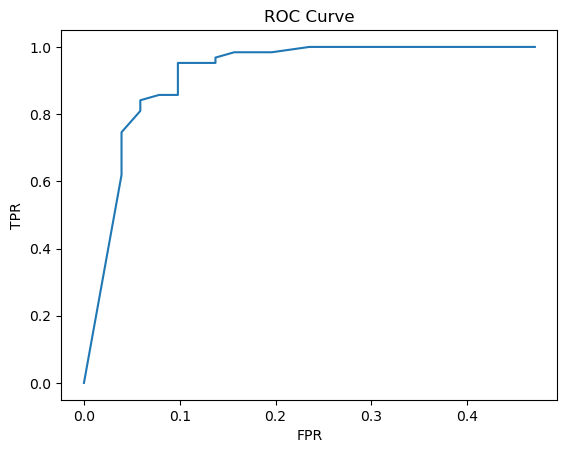

In [21]:
rf_fpr, rf_tpr = accuracy_metrics.roc_curve(rf, df_test, tf_test)

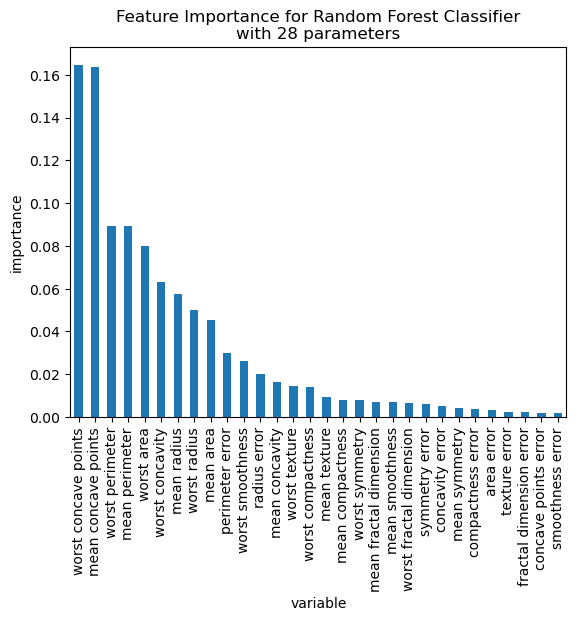

In [22]:
feature_importance = pd.Series(rf.feature_importances_, index = df_train.columns).sort_values(ascending = False)
feature_importance.plot.bar()
plt.xlabel('variable')
plt.ylabel('importance')
plt.title('Feature Importance for Random Forest Classifier\nwith 28 parameters')
plt.show()

The random forest classification method chose the 3 most important features to be `worst concave points`, `mean concave points`, and `worst perimeter`. This differs from features choosen by our other feature selection methods made as well as our decision tree. 

# Conclusion 

For this dataset, we want the false negative rate to be as low as possible and the false positive rate is less important. That is because the consequences of a false negative (classifying a tumor as malignant rather than cancerous) has far greater consequences than a false negative. Using the false positive rate as primary factor in comparing our different classification models, the features selected using sparse mixed effect with a logisitc model performed the best. On the testing dataset it had the highest $F_1score$ (0.9670). This indicates that on average our model has good precision and recall. If we compare the ROC curves of each model, we can see that this model also has the greatest ROC AUC (area under the curve). The ROC AUC metric measures how well the classifier identifies between the malignant and cancerous tumors. The worst model in terms of false negative rate was the random forest model. It's ROC curve is the furthest away from the y-axis which means that its AUC score would be the lowest (meaning it has the lowest accuarcy rate of the models). 

Here we see that adding interaction terms to our linear model for feature selection resulted in the best classification data for this dataset using the false positive rate as the primary metric.